In [1]:
import torch

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [5]:
# Hyper-parameters 
num_epochs = 5
batch_size = 4
learning_rate = 0.001

In [6]:
# dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


In [7]:
# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [8]:
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified


In [9]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

In [10]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

In [11]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [12]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


In [13]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

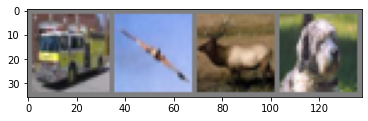

In [14]:
# show images
imshow(torchvision.utils.make_grid(images))


In [15]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 5, 5
        x = x.view(-1, 16 * 5 * 5)            # -> n, 400
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 10
        return x



In [16]:
model = ConvNet().to(device)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [18]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [1/5], Step [2000/12500], Loss: 2.2828
Epoch [1/5], Step [4000/12500], Loss: 2.2777
Epoch [1/5], Step [6000/12500], Loss: 2.2784
Epoch [1/5], Step [8000/12500], Loss: 2.2984
Epoch [1/5], Step [10000/12500], Loss: 2.0610
Epoch [1/5], Step [12000/12500], Loss: 2.2551
Epoch [2/5], Step [2000/12500], Loss: 3.2705
Epoch [2/5], Step [4000/12500], Loss: 2.4986
Epoch [2/5], Step [6000/12500], Loss: 1.9300
Epoch [2/5], Step [8000/12500], Loss: 1.6486
Epoch [2/5], Step [10000/12500], Loss: 1.8001
Epoch [2/5], Step [12000/12500], Loss: 1.9237
Epoch [3/5], Step [2000/12500], Loss: 2.1623
Epoch [3/5], Step [4000/12500], Loss: 2.0494
Epoch [3/5], Step [6000/12500], Loss: 2.5291
Epoch [3/5], Step [8000/12500], Loss: 1.7743
Epoch [3/5], Step [10000/12500], Loss: 1.5827
Epoch [3/5], Step [12000/12500], Loss: 1.4445
Epoch [4/5], Step [2000/12500], Loss: 0.9525
Epoch [4/5], Step [4000/12500], Loss: 1.7037
Epoch [4/5], Step [6000/12500], Loss: 1.6090
Epoch [4/5], Step [8000/12500], Loss: 1.0576
Epoc

In [19]:
print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

Finished Training


In [20]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

In [21]:
acc = 100.0 * n_correct / n_samples
print(f'Accuracy of the network: {acc} %')

Accuracy of the network: 45.91 %


In [22]:
for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of plane: 41.0 %
Accuracy of car: 40.0 %
Accuracy of bird: 21.1 %
Accuracy of cat: 39.3 %
Accuracy of deer: 33.9 %
Accuracy of dog: 47.1 %
Accuracy of frog: 67.2 %
Accuracy of horse: 49.1 %
Accuracy of ship: 55.0 %
Accuracy of truck: 65.4 %
